In [1]:
from utils.utils import save, load

from selenium import webdriver

# from itertools import product, islice
from itertools import islice
from time import sleep
from collections import OrderedDict
import re
import argparse

In [2]:
"""
Enable passing some keyword arguments from command line.
This does not affect the Jupyter notebook.
"""
# try:
parser = argparse.ArgumentParser()

parser.add_argument('--start', action='store', dest='start',
                    help='Specify the starting iteration number', 
                    type=int,
                    default=None)

parser.add_argument('--stop', action='store', dest='stop',
                    help='Specify the stopping iteration number', 
                    type=int, 
                    default=None)

#     results = parser.parse_args()
args, unknown = parser.parse_known_args()

# if args.logdir is not None and isinstance(args.logdir, str):
#     kwargs_simple_rnn.log_dir = str(args.logdir)

start_itr = args.start
stop_itr = args.stop

sub_dir = 'scrape/'

In [ ]:
# all wiki articles of the ATC-code category can be found here
petscan_url = 'https://petscan.wmflabs.org/?psid=1039824'

# some constants regarding the articles in this category
right_table_css_select = '#mw-content-text > table.float-right.infobox.wikitable'
# fields to look for in the table ('Name' is matched from the header)
var_name_list = ['Name', 
                 'ATC-Code', 
                 'Andere Namen', 
                 'CAS-Nummer', 
                 'PubChem', 
                 'Kurzbeschreibung', 
                 'PubMed-Suche', 
                 'Summenformel', 
                 'DrugBank', 
                 'Wirkstoffklasse', 
                 'Wirkmechanismus']

In [ ]:
driver = webdriver.Firefox()
driver.delete_all_cookies()
driver.get(petscan_url)
driver.implicitly_wait(2)  # seconds

In [ ]:
# find all table rows that contain the
# given partial_text, on the first (left) table cell
find_row_by_text = lambda partial_text, row_list: \
    [row for row in row_list 
     if partial_text in row.find_elements_by_tag_name('td')[0].text]

# get the text from the second (right) table cell
get_right_cell_of_row = lambda row: \
    row.find_elements_by_tag_name('td')[1].text\
    .split('\n')

strip_ref = lambda text: re.sub(r'\[.+?\]\s*', '', text)

def get_table_data(partial_text, row_list, d=driver):
    """
    Looks for a row in the 'row_list'
    containing 'partial_text' and
    returns (partial_text, [values]).
    In case the partial_text is not found, values are None.
    Removes numbers, used by Wikipedia for references.
    """
    if partial_text == 'Name':
        return (partial_text, 
                [d.find_element_by_id('firstHeading').text])
    atc_row = find_row_by_text(partial_text, right_table_rows)
    if len(atc_row) == 0:
        values = [None]
    else:
        assert len(atc_row) == 1
        atc_row = atc_row[0]
        values = [strip_ref(elem) 
                  for elem in get_right_cell_of_row(atc_row)]
    return (partial_text, values)

In [ ]:
# get all links tp wiki articles from the ATC-code category 
petscan_results_id = 'main_table'
petscan_results = driver.find_element_by_id(petscan_results_id)
petscan_results = petscan_results.find_elements_by_tag_name('a')
petscan_results_links = [elem.get_attribute('href') 
                         for elem in petscan_results]

In [ ]:
# iterate through all links and collect results
data_collector_list = []


if start_itr is None:
    start_itr = 1000
if stop_itr is None:
    stop_itr = len(petscan_results_links)
    
print('Starting at {}'.format(start_itr))
print('Stopping at {}'.format(stop_itr))

petscan_results_links = enumerate(petscan_results_links)

iterable = islice(petscan_results_links, 
                  start_itr, 
                  stop_itr)

for step, art_link in iterable:
    print('step number {}'.format(step))
    driver.get(art_link)
    sleep(0.1)
    
    # try, since some pages are really weird, such as
    # https://de.wikipedia.org/wiki/Ginkgo
    try:
        # get rows of the table on the right
        right_table = driver.find_element_by_css_selector(right_table_css_select)
        right_table_rows = right_table.find_elements_by_tag_name('tr')

        # keep rows with exactly 2 columns
        right_table_rows = \
            [row for row in right_table_rows 
             if len(row.find_elements_by_tag_name('td')) == 2]

        data_collector_list.append(
            OrderedDict([get_table_data(var, right_table_rows) 
                         for var in var_name_list]))
    except:
        print('Encountered a very weird article!')
        print('Step number {}, article named {}'.
              format(step, get_table_data('Name', [])[0]))
        print('Skipping to the next page.')
        

In [ ]:
print('Done scraping!')
print('Saving now')

In [ ]:
# print(data_collector_list)

def keep_unique(seq):
    seen = []wiki_df_filtered
    seen_add = seen.append
    return [x for x in seq if not (x in seen or seen_add(x))]

data_collector_list_unique = \
    keep_unique(data_collector_list)

save(fname=sub_dir+'wikipedia_raw_data_collector_num_{}_{}'.\
     format(start_itr, stop_itr),
     obj=data_collector_list_unique)

In [ ]:
print('Done saving!')

In [ ]:
driver.close()

In [3]:
"""
Load raw data from file.
"""

from os import listdir
from os.path import isfile, join
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

flatten_list = lambda l: [item for sublist in l for item in sublist]

wiki_raw_data_files = \
    [join(sub_dir, f) 
     for f in listdir(sub_dir) 
     if isfile(join(sub_dir, f)) and 
     'wikipedia_raw_data_collector_num_' in join(sub_dir, f)]

In [4]:
wiki_raw_data_dict = {k:load(v) for k,v 
                      in enumerate(wiki_raw_data_files)}

In [5]:
wiki_raw_data = flatten_list(list(
    wiki_raw_data_dict.values()))

In [6]:
wiki_df = pd.DataFrame(wiki_raw_data)

valid_len = lambda x: 0 if x==[None] else len(x)
wiki_df_len = wiki_df.applymap(valid_len)

print('The Wikipedia.de raw files contain {} entries.'.format(len(wiki_df)))

The Wikipedia.de raw files contain 1635 entries.


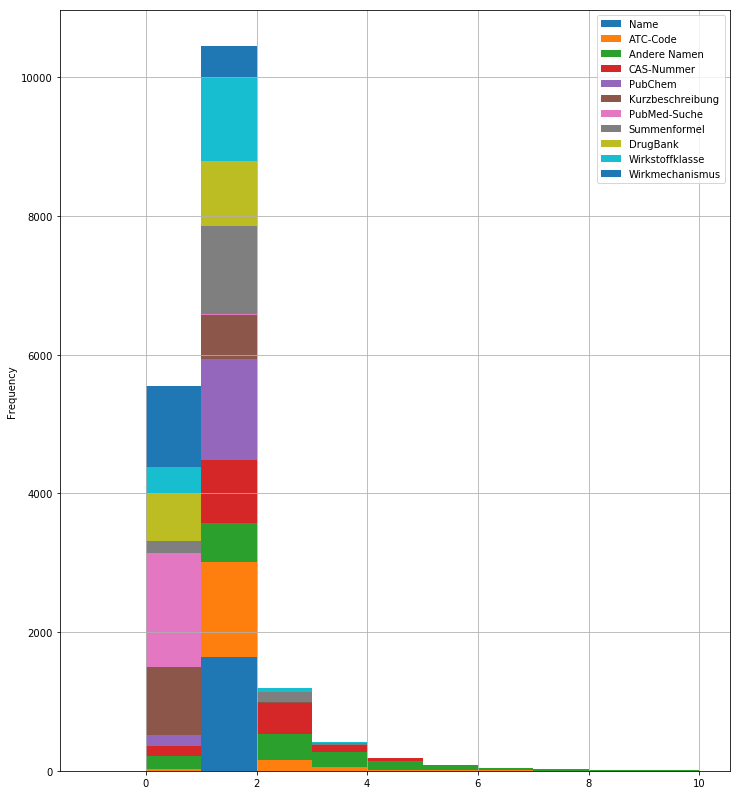

In [7]:
# wiki_df_len.head(5)

# plt.figure();
wiki_df_len.plot.hist(stacked=True, 
                      alpha=1.0, 
                      figsize=(12, 14), 
                      grid=True, bins=range(-1, 10+1))

In [8]:
# wiki_df.drop(wiki_df[wiki_df.Name !=1])
wiki_df_filtered = \
    wiki_df.drop(wiki_df[
        (wiki_df_len['Name'] !=1) | \
        (wiki_df_len['ATC-Code'] !=1)].index)

print('After keeping only entries with one name and one ATC-code, ' +\
      'we are left with {} entries'.format(len(wiki_df_filtered)))

After keeping only entries with one name and one ATC-code, we are left with 1379 entries


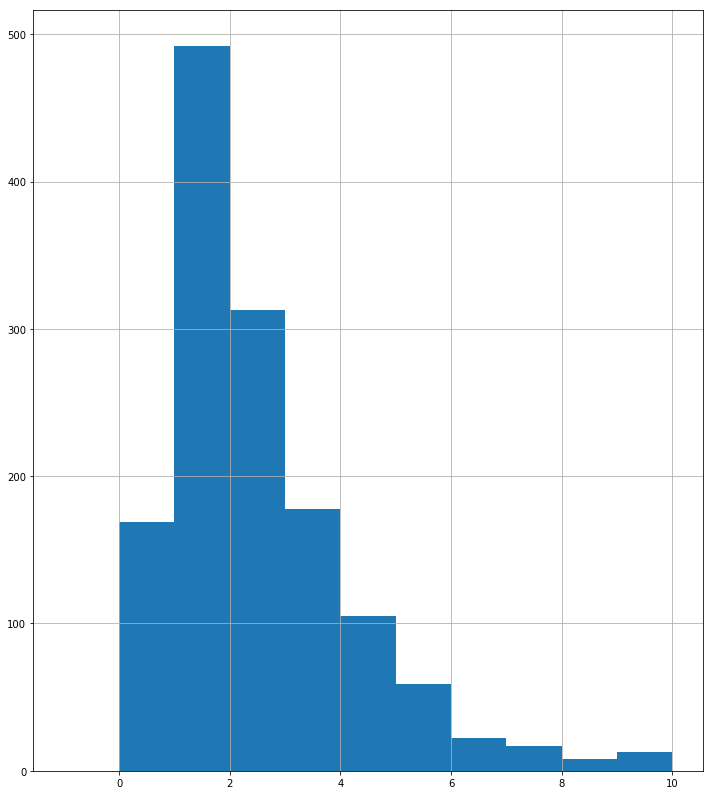

In [9]:
wiki_df_filtered['Andere Namen'].apply(valid_len)\
    .hist(stacked=True, 
          alpha=1.0, 
          figsize=(12, 14), 
          grid=True, 
          bins=range(-1, 10+1))

In [10]:
collector_other_names = []
# iterable = islice(wiki_df_filtered.iterrows(), 0, 30)
iterable = wiki_df_filtered.iterrows()

for index, df_row in iterable:
    other_names = df_row['Andere Namen']
    if other_names == [None]:
        continue
    new_candidate_rows = [OrderedDict(df_row) 
                          for name in other_names]
    
    for k, name in enumerate(other_names):
        new_candidate_rows[k]['Name'] = [name]
    
    collector_other_names.extend(new_candidate_rows)

In [11]:
print('Created {} additional rows from "Other Names (Andere Namen)"'.\
      format(len(collector_other_names)))

Created 2833 additional rows from "Other Names (Andere Namen)"


In [12]:
wiki_df_other_names = \
    pd.DataFrame(collector_other_names, 
                 index=range(
                     max(wiki_df_filtered.index), 
                     max(wiki_df_filtered.index)+\
                         len(collector_other_names)))

In [13]:
# concat the two DataFrames into a single one
wiki_df_merged = \
    pd.concat([wiki_df_filtered[['Name', 'ATC-Code']], 
               wiki_df_other_names[['Name', 'ATC-Code']]],
               ignore_index=True)

In [14]:
wiki_df_merged

,Name,ATC-Code
0,[Nebivolol],[C07AB12]
1,[Afamelanotid],[D02BB02]
2,[Ergocalciferol],[A11CC01]
3,[Pindolol],[C07AA03]
4,[Apramycin],[QA07AA92]
5,[Flupentixol],[N05AF01]
6,[Lenalidomid],[L04AX04]
7,[Sotalol],[C07AA07]
8,[Alprenolol],[C07AA01]
9,[Lercanidipin],[C08CA13]


In [16]:
pop = lambda x: x[0]
wiki_df_merged = wiki_df_merged.applymap(pop)
wiki_df_merged.head(5)

,Name,ATC-Code
0,Nebivolol,C07AB12
1,Afamelanotid,D02BB02
2,Ergocalciferol,A11CC01
3,Pindolol,C07AA03
4,Apramycin,QA07AA92
